In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
df=pd.concat([train, test], axis=0)
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      12988

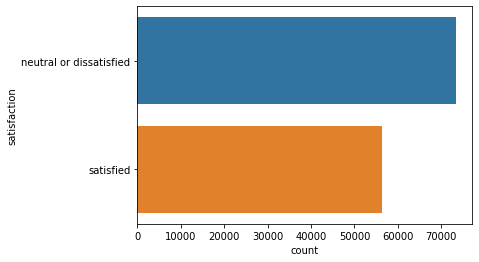

In [4]:
c_palette = ['tab:blue', 'tab:orange']
sns.countplot(data=df, y = 'satisfaction', palette=c_palette)

Pogledajmo koliko jedinstvenih vrijednosti ima svaki od naših kategorijalnih stupaca.

In [5]:
print ("Type of travel: ", df['Type of Travel'].unique())
print ("Class: ", df['Class'].unique())
print ("Gender: ", df['Gender'].unique())
print ("Customer Type: ", df['Customer Type'].unique())
print ("Satisfaction: ", df['satisfaction'].unique())

Type of travel:  ['Personal Travel' 'Business travel']
Class:  ['Eco Plus' 'Business' 'Eco']
Gender:  ['Male' 'Female']
Customer Type:  ['Loyal Customer' 'disloyal Customer']
Satisfaction:  ['neutral or dissatisfied' 'satisfied']


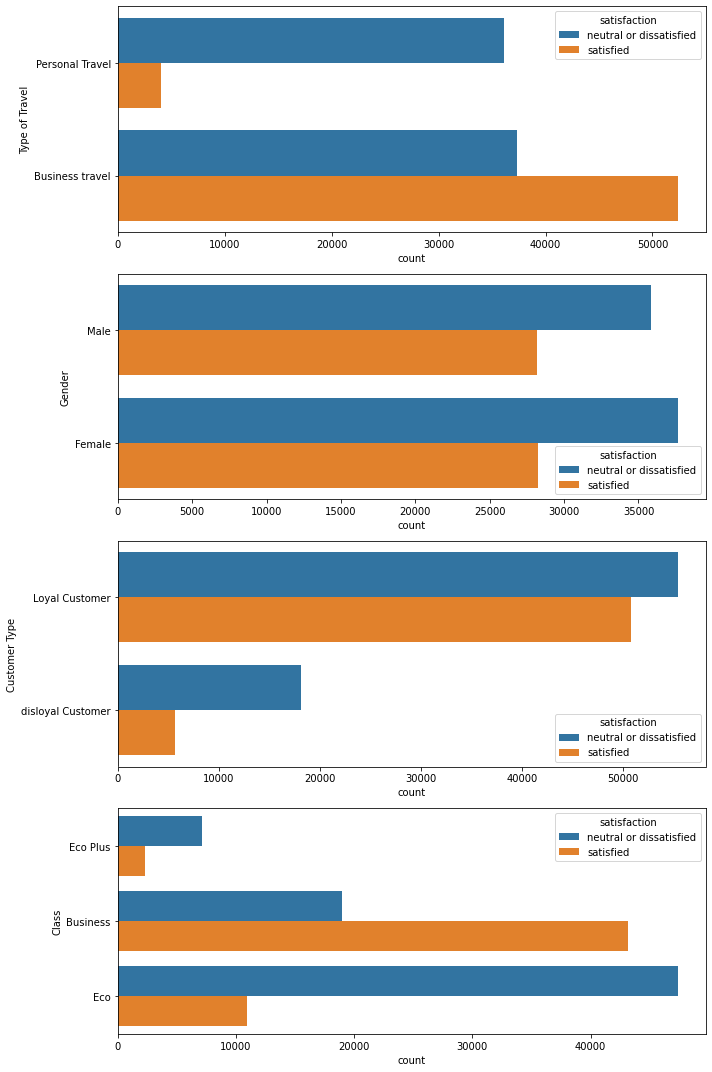

In [6]:
fig, axes = plt.subplots(nrows=4, figsize=(10,15))

sns.countplot(data=df, y = 'Type of Travel', hue='satisfaction', palette=c_palette, ax=axes[0])
sns.countplot(data=df, y = 'Gender', hue='satisfaction', palette=c_palette, ax=axes[1])
sns.countplot(data=df, y = 'Customer Type', hue='satisfaction', palette=c_palette, ax=axes[2])
sns.countplot(data=df, y = 'Class', hue='satisfaction', palette=c_palette, ax=axes[3])

fig.tight_layout()

Vidimo da nam ne treba stupac <code>Unnamed</code> koji je samo preslika indexa i stupac <code>id</code> koji je jedinstveni broj za svakog putnika.

In [7]:
df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

Provjerimo imamo li vrijednosti koje nedostaju i koliki je njihov postotak.

In [8]:
df.isnull().sum()/len(df)

Gender                               0.000000
Customer Type                        0.000000
Age                                  0.000000
Type of Travel                       0.000000
Class                                0.000000
Flight Distance                      0.000000
Inflight wifi service                0.000000
Departure/Arrival time convenient    0.000000
Ease of Online booking               0.000000
Gate location                        0.000000
Food and drink                       0.000000
Online boarding                      0.000000
Seat comfort                         0.000000
Inflight entertainment               0.000000
On-board service                     0.000000
Leg room service                     0.000000
Baggage handling                     0.000000
Checkin service                      0.000000
Inflight service                     0.000000
Cleanliness                          0.000000
Departure Delay in Minutes           0.000000
Arrival Delay in Minutes          

Dakle, samo u jednom stupcu imamo missing values i to jako mali postotak pa redove u kojima se nalaze možemo bez problema izbaciti.

In [9]:
df.dropna(axis=0,inplace=True)

Primjenimo sada FAMD (Factor analysis of mixed data) metodu na naše podatke da bi izračunali objašnjenu varijancu. FAMD je kombinacija PCA i MCA za podatke koji u sebi imaju i numeričke i kategorijalne varijable.

In [10]:
import pandas as pd
import prince
import pprint

## Instantiate FAMD object
famd = prince.FAMD(
     n_components=22,  
     n_iter=10,
     copy=True,
     check_input=True,
     engine='auto',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42)

## Fit FAMD object to data 
famd = famd.fit(df.drop('satisfaction', axis=1)) 

df1 = df.drop('satisfaction', axis=1)
## Inspect principal dimensions
pp = pprint.PrettyPrinter()
pp.pprint(famd.explained_inertia_) 

[0.5628361906990973,
 0.171181109110184,
 0.1252233869893698,
 0.08745525424548074,
 0.029950860452348318,
 0.02334980944886895,
 6.8674630132621e-07,
 4.726353794506904e-07,
 4.1993106232402543e-07,
 3.922714651492412e-07,
 2.1002562262473737e-07,
 1.7811439331336323e-07,
 1.760294203395289e-07,
 1.4881631832081475e-07,
 1.3685736616364647e-07,
 9.770966296344003e-08,
 9.414764344046867e-08,
 8.76243299461151e-08,
 7.32576868322838e-08,
 6.369193703417903e-08,
 5.857295846549576e-08,
 4.95901113943221e-08]


Prve četiri značajke imaju velik udio u objašnjenoj varijanci.

Pretvorimo sada kategorijalne varijable u intove.

In [11]:
gender_mapper = {'Male': 0, 'Female': 1}
df['Gender'].replace(gender_mapper, inplace=True)
type_mapper = {'Personal Travel': 0, 'Business travel': 1}
df['Type of Travel'].replace(type_mapper, inplace=True)
cust_mapper = {'Loyal Customer': 0, 'disloyal Customer': 1}
df['Customer Type'].replace(cust_mapper, inplace=True)
satisfaction_mapper = {'neutral or dissatisfied': 0, 'satisfied': 1}
df['satisfaction'].replace(satisfaction_mapper, inplace=True)

df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,0,13,0,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,0,1,25,1,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,1,0,26,1,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,1,0,25,1,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,0,0,61,1,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


Encodali smo sve kategorijalne vrijednosti osim onih u stupcu <code>Class</code> jer tamo imamo više od dvije. Budući da ne želimo nejednake težne, ovaj ćemo stupac One Hot Encodati.

In [12]:
df['Class'] = pd.Categorical(df['Class'])
dfDummies = pd.get_dummies(df['Class'], prefix = 'Class')
df = pd.concat([df, dfDummies], axis=1)
df.drop('Class', axis=1, inplace=True)

Rješavanje koreliranih featurea:

In [13]:
correlated_features = set()
correlation_matrix = df.drop('satisfaction', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
correlated_features

{'Arrival Delay in Minutes', 'Class_Eco'}

In [14]:
df.drop(correlated_features, axis=1, inplace=True)

In [15]:
df1 = df.pop('satisfaction')
df['satisfaction']=df1
df.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Class_Business,Class_Eco Plus,satisfaction
0,0,0,13,0,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0,1,0
1,0,1,25,1,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,1,0,0
2,1,0,26,1,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1,0,1
3,1,0,25,1,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,1,0,0
4,0,0,61,1,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1,0,1


Analizirajmo prvo dataset uz pomoć pojedinačnih histograma za svaku od značajki i za svaki ishod ciljne varijable.

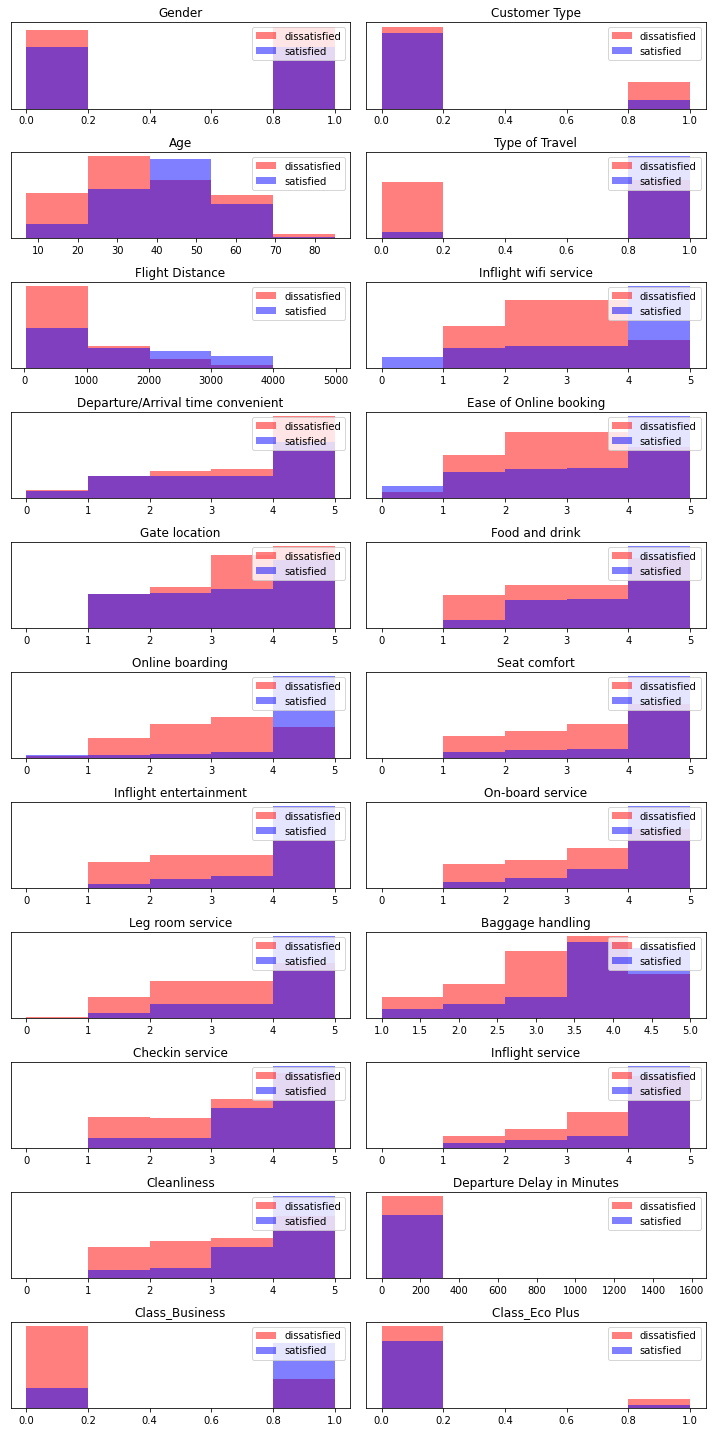

In [16]:
dissatisfied = df.loc[ df['satisfaction'] == 0, : ]
satisfied = df.loc[ df['satisfaction'] == 1, : ]

fig, axes = plt.subplots(11, 2, figsize=(10, 20))
ax = axes.ravel() # axes are 2-dimensional so we unfold them
for i in range(22):
    _, bins = np.histogram(df.iloc[:,i], bins=5) # bins 5 ili 50 ovisno koji graf želimo gledat
    ax[i].hist(dissatisfied.iloc[:,i], bins=bins, color='r', alpha=.5, label='dissatisfied')
    ax[i].hist(satisfied.iloc[:,i], bins=bins, color='b', alpha=.5, label='satisfied')
    ax[i].set_title(df.columns.values[i])
    ax[i].set_yticks(()) # remove ticks on y-axis
    ax[i].legend(loc='upper right')
fig.tight_layout()

Online boarding i class business se čine kao značajke kod koje su klase (dissatisfied i satisfied) najrazdvojenije.

Standardizirajmo sve značajke s funkcijom <code>sklearn.preprocessing.StandardScaler</code> koja oduzima srednju vrijednost i standardizira sve značajke tako da imaju jediničnu varijancu. Nakon toga iskoristit ćemo analizu glavnih komponenti (engl. principal component analysis, PCA) da projiciramo naše podatke u novi prostor značajki (komponenti) gdje su one ortogonalne i poredane po količini varijance koju objašnjavaju u originalnim podacima.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [18]:
scaler = StandardScaler()
X = df.drop('satisfaction',axis=1)
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA() 
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled) 
print("Dimenzije originalnih podataka: %s" % str(X_scaled.shape))
print("Dimenzije projiciranih podataka: %s" % str(X_pca.shape))

Dimenzije originalnih podataka: (129487, 22)
Dimenzije projiciranih podataka: (129487, 22)


In [19]:
df_pca = pd.DataFrame(X_pca, columns=['PC'+str(i) for i in range(1,X_pca.shape[1]+1)])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
0,-1.189188,0.625753,0.610313,3.909748,0.391552,-0.588160,1.629375,-0.720081,0.664936,2.733001,0.750835,0.658164,-0.363977,0.384712,-0.859685,-0.040936,0.578130,0.126559,0.598589,0.608757,-0.273961,-0.017986
1,2.973611,-0.678740,-1.756017,-2.274276,2.047526,0.218448,0.684507,-1.319092,0.267474,-0.655173,0.652097,-1.085848,-0.733347,-1.008063,-0.729461,0.438003,0.816017,-0.718581,-0.129066,0.762896,0.689193,-0.157250
2,-2.417703,1.843516,1.079428,-0.038354,0.465028,-0.712269,-0.817764,0.512723,-0.123895,0.450653,0.630814,0.494454,-1.051004,0.013752,-0.028666,-0.215346,-0.030774,-0.270836,-0.284605,-0.209608,-0.143243,-0.078286
3,1.453396,-2.236604,-1.008766,-1.206407,0.527614,0.659674,0.028555,0.295005,-2.222198,-0.263101,0.262105,-1.267782,-1.724321,-0.425282,-0.819671,-0.231674,0.724045,-0.209683,-0.118825,0.344931,-0.852342,0.149880
4,-1.145437,-0.229835,0.895914,-0.879725,-0.579708,-0.148990,0.395959,-1.094260,0.912853,-1.141641,-0.645642,-0.282364,-1.159272,-0.490669,-0.440770,0.180540,-0.557901,-0.719222,0.603839,-0.238121,0.150071,0.214706


Možemo prikazati varijancu objašnjenu sa svakom od glavnih komponenti, kao i kumulativnu varijancu objašnjenu uključivanjem svake naredne glavne komponente u našem projiciranom datasetu.

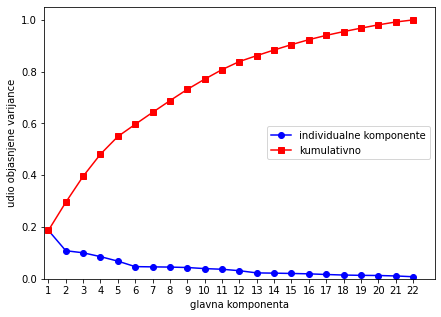

In [20]:
plt.figure(figsize=(7,5))

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cummulative = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio, '-o', label='individualne komponente', c='b')
plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio_cummulative, '-s', label='kumulativno', c='r')

plt.ylabel('udio objasnjene varijance')
plt.xlabel('glavna komponenta')
plt.xlim(0.75,X_pca.shape[1]+1.25)
plt.ylim(0,1.05)
plt.xticks(range(1,X_pca.shape[1]+1))
plt.legend(loc='center right')
plt.show()

Prema gornjem rezultatu naslućujemo da nećemo moći značajno reducirati broj značajki.

## Odabir značajki - pokušaj

### Rekurzivna eliminacija značajki s unakrsnom validacijom - Random Forest

In [21]:
train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

rfecv = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv.fit(X_train, y_train);

In [22]:
print('Optimalni broj featurea: {}'.format(rfecv.n_features_))

Optimalni broj featurea: 18


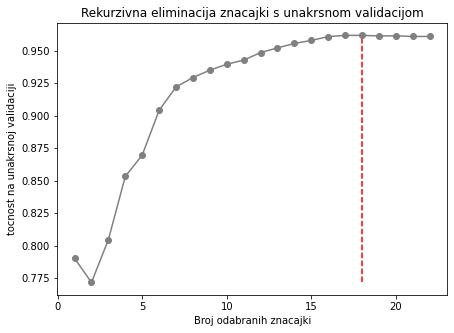

In [23]:
plt.figure(figsize=(7,5))

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, '-o',color='gray')
plt.xlabel('Broj odabranih znacajki')
plt.ylabel('tocnost na unakrsnoj validaciji')
plt.title('Rekurzivna eliminacija znacajki s unakrsnom validacijom')
plt.vlines(rfecv.n_features_, 
           np.min(rfecv.grid_scores_), 
           rfecv.grid_scores_[rfecv.n_features_-1], 
           color='red', linestyle='--')
plt.show()

In [24]:
print("Stupci za izbaciti: ", X_train.columns[np.where(rfecv.support_ == False)[0]])

Stupci za izbaciti:  Index(['Gender', 'Food and drink', 'Departure Delay in Minutes',
       'Class_Eco Plus'],
      dtype='object')


In [25]:
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

Pokušajmo sada vizualizirati važnost preostalih featurea:

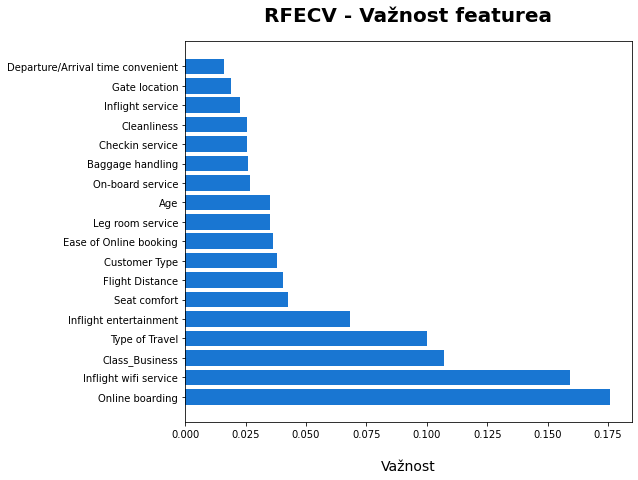

In [26]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(8, 7))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Važnost featurea', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Važnost', fontsize=14, labelpad=20)
plt.show()

Kao što vidimo, posljednja četri featurea imaju znatno veću važnost od ostalih, tako da model možemo pokušati konstruirati samo i sa ova četri stupca te vidjeti koliku točnost dobivamo. 

### Chi2

                     Specs         Score
8          Online boarding  14562.776630
17          Class_Business  13530.333730
10  Inflight entertainment   8760.811006
2           Type of Travel   6429.416114
9             Seat comfort   6380.660365
3    Inflight wifi service   5412.930489
11        On-board service   5320.310888
12        Leg room service   5224.078238
16             Cleanliness   5124.531783
1            Customer Type   2935.206653


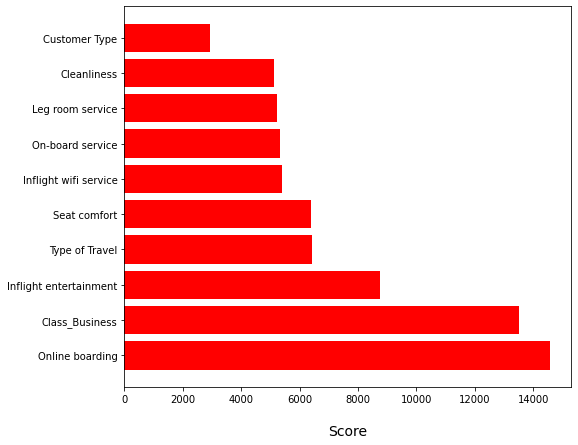

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

train, test = train_test_split(df, test_size=0.20, random_state=42)

X_train = train.drop(['satisfaction', 'Age', 'Flight Distance', 'Departure Delay in Minutes'],axis=1)
y_train = train['satisfaction']

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))

plt.figure(figsize=(8, 7))
plt.barh(y=featureScores.nlargest(10,'Score')['Specs'], width=featureScores.nlargest(10,'Score')['Score'], color='red')
plt.xlabel('Score', fontsize=14, labelpad=20)
plt.show()

### Heatmap

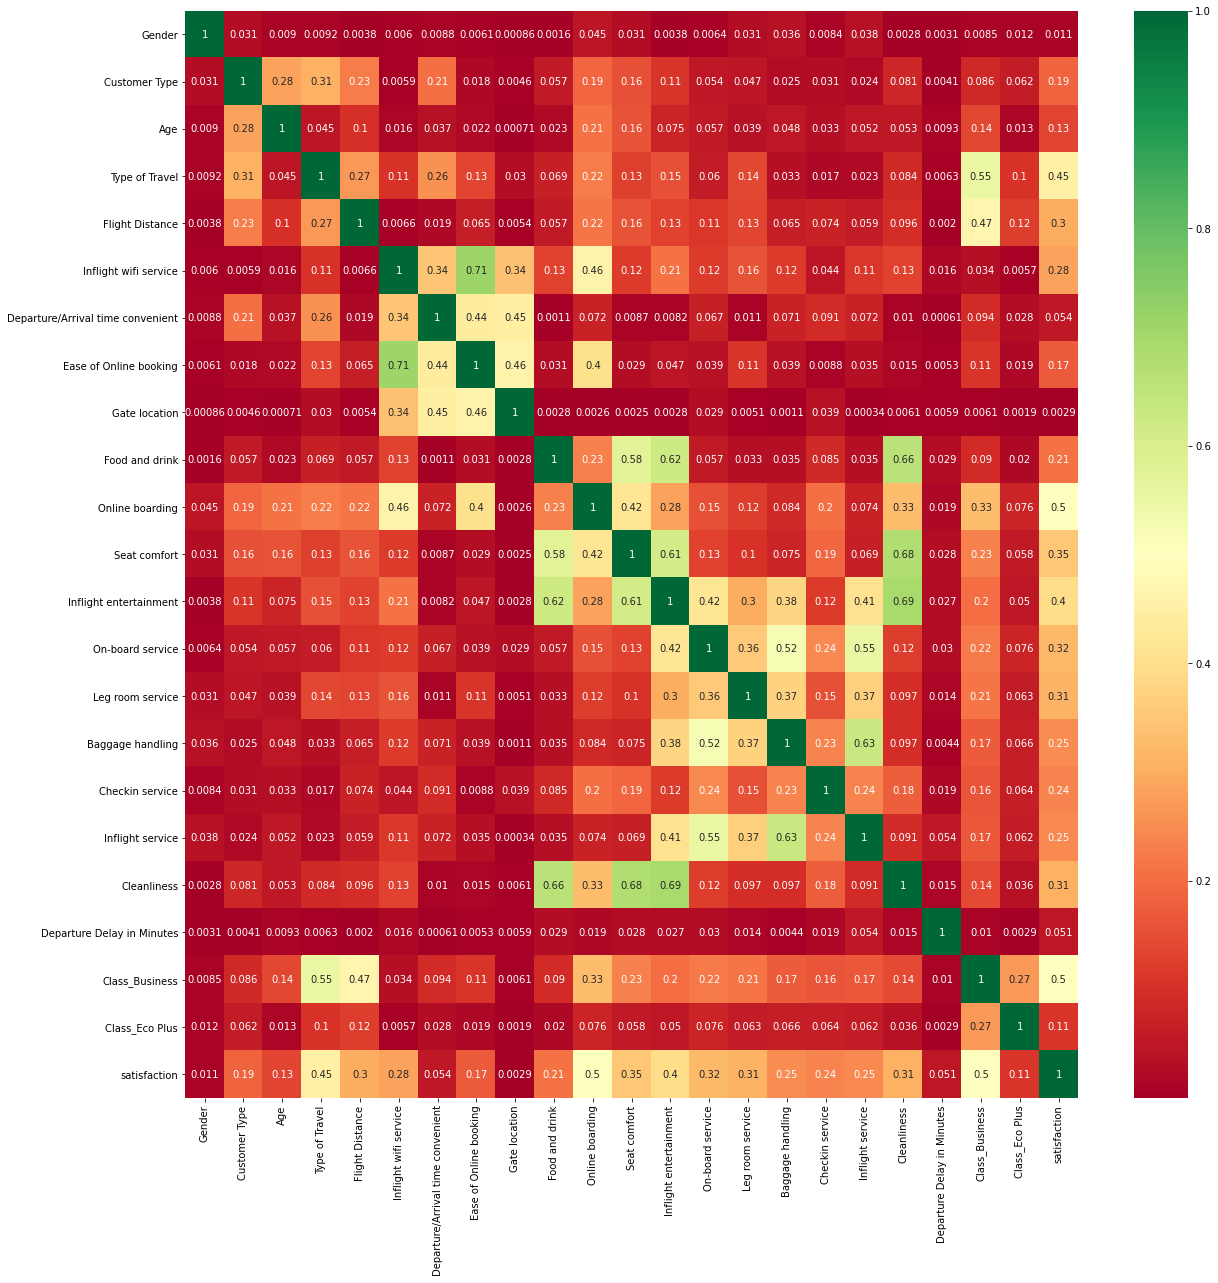

In [28]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(abs(df[top_corr_features].corr()),annot=True,cmap="RdYlGn")

Iz heatmapa vidimo da je zadovoljstvo visoko korelirano s vrstom putovanja, online boardingom i s time radi li se o business klasi, dok je najslabije korelirana s lokacijom vrata i spolom putnika.

### Extra Trees Classifier

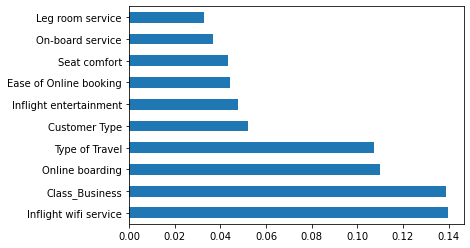

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

model = ExtraTreesClassifier()
model.fit(X_train,y_train)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

rfecv_lr = RFECV(LogisticRegression(solver='liblinear'), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv_lr.fit(X_train, y_train);

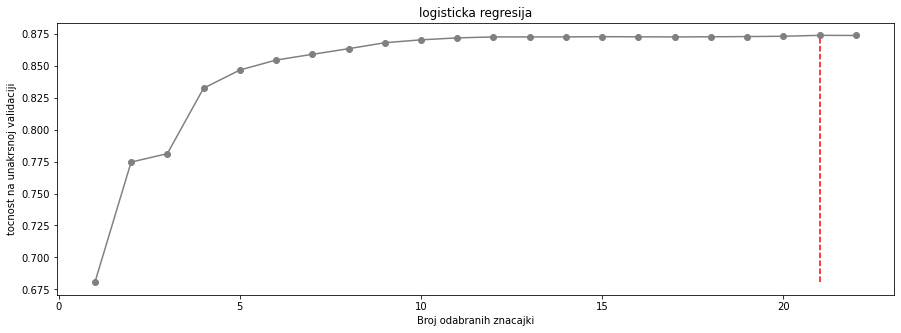

In [31]:
fig, ax = plt.subplots(1, figsize=(15, 5))

ax.plot(range(1, len(rfecv_lr.grid_scores_) + 1), rfecv_lr.grid_scores_, '-o', color='gray')
ax.set(xlabel='Broj odabranih znacajki',ylabel='tocnost na unakrsnoj validaciji',title='logisticka regresija')
ax.vlines(rfecv_lr.n_features_, 
             np.min(rfecv_lr.grid_scores_), 
             rfecv_lr.grid_scores_[rfecv_lr.n_features_-1], 
             color='red', linestyle='--')

plt.show()

In [32]:
print("Stupci za izbaciti: ", X_train.columns[np.where(rfecv_lr.support_ == False)[0]])

Stupci za izbaciti:  Index(['Flight Distance'], dtype='object')


### Mutual Information

In [33]:
from sklearn.feature_selection import mutual_info_classif

train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

info = mutual_info_classif(X_train, y_train, discrete_features=True)
dfscores = pd.DataFrame(info)
dfcolumns = pd.DataFrame(X_train.columns)

fs = pd.concat([dfcolumns,dfscores],axis=1)
fs.columns = ['Specs','Score']  
print(fs.nlargest(10,'Score'))

                     Specs     Score
10         Online boarding  0.210167
5    Inflight wifi service  0.163377
20          Class_Business  0.130991
3           Type of Travel  0.113067
12  Inflight entertainment  0.094225
4          Flight Distance  0.080697
11            Seat comfort  0.078252
14        Leg room service  0.060124
13        On-board service  0.057792
18             Cleanliness  0.052406


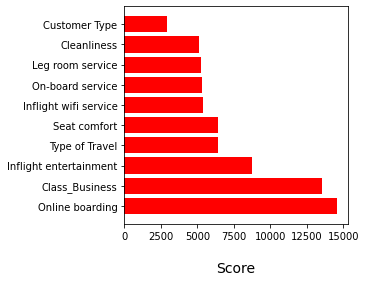

In [34]:
plt.figure(figsize=(4, 4))
plt.barh(y=featureScores.nlargest(10,'Score')['Specs'], width=featureScores.nlargest(10,'Score')['Score'], color='red')
plt.xlabel('Score', fontsize=14, labelpad=20)
plt.show()

## Novo

### Logistička regresija

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
# za roc
from sklearn.metrics import roc_auc_score , roc_curve

ROC Score= 0.913226435
Accuracy=  0.871110 


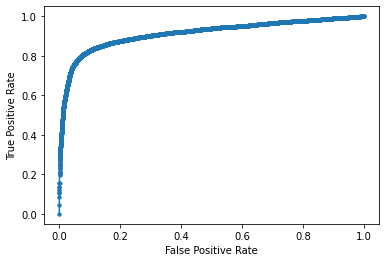

In [36]:
train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']


model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('logistic', LogisticRegression(solver='liblinear'))])
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()
y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [37]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Class_Business,Class_Eco Plus,satisfaction
0,0,0,13,0,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0,1,0
1,0,1,25,1,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,1,0,0
2,1,0,26,1,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1,0,1
3,1,0,25,1,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,1,0,0
4,0,0,61,1,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1,0,1


In [38]:
df1 = df[['Online boarding', 'Inflight wifi service', 'Class_Business', 'Type of Travel', 'Inflight entertainment',
          'satisfaction', 'Cleanliness', 'Seat comfort', 'Leg room service','On-board service']]

df1.head()

,Online boarding,Inflight wifi service,Class_Business,Type of Travel,Inflight entertainment,satisfaction,Cleanliness,Seat comfort,Leg room service,On-board service
0,3,3,0,0,5,0,5,5,3,4
1,3,3,1,1,1,0,1,1,5,1
2,5,2,1,1,5,1,5,5,3,4
3,2,2,1,1,2,0,2,2,5,2
4,5,3,1,1,3,1,3,5,4,3


In [39]:
df2 = df[['Customer Type', 'Cleanliness', 'Leg room service', 'On-board service', 'Inflight wifi service', 'Seat comfort',
         'Type of Travel', 'Inflight entertainment', 'Class_Business', 'Online boarding', 'satisfaction']]
df2.head()

,Customer Type,Cleanliness,Leg room service,On-board service,Inflight wifi service,Seat comfort,Type of Travel,Inflight entertainment,Class_Business,Online boarding,satisfaction
0,0,5,3,4,3,5,0,5,0,3,0
1,1,1,5,1,3,1,1,1,1,3,0
2,0,5,3,4,2,5,1,5,1,5,1
3,0,2,5,2,2,2,1,2,1,2,0
4,0,3,4,3,3,5,1,3,1,5,1


ROC Score= 0.969846849
Accuracy=  0.911460 


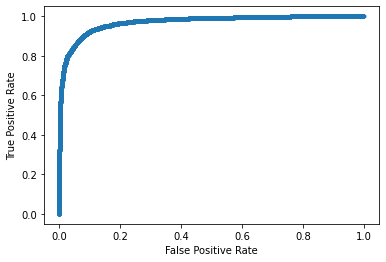

In [40]:
#'Online boarding', 'Inflight wifi service', 'Class_Business', 'Type of Travel', 'Inflight entertainment',
#          'satisfaction', 'Cleanliness', 'Seat comfort', 'Leg room service','On-board service'

train, test = train_test_split(df1, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']


model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('logistic', LogisticRegression(solver='liblinear'))])
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()
y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

ROC Score= 0.979328578
Accuracy=  0.927909 


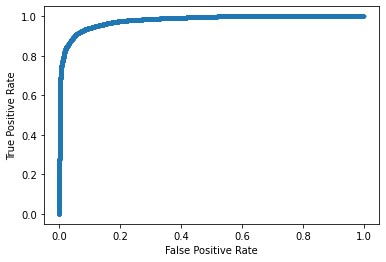

In [41]:
#'Online boarding', 'Inflight wifi service', 'Class_Business', 'Type of Travel', 'Inflight entertainment',
#          'satisfaction', 'Cleanliness', 'On-board service', 'Leg room service','Seat comfort'

train, test = train_test_split(df1, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']


model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('logistic', LogisticRegression(solver='liblinear'))])
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()
y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

ROC Score= 0.982443306
Accuracy=  0.933701 


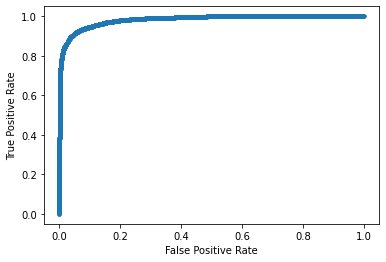

In [42]:
#'Online boarding', 'Inflight wifi service', 'Class_Business', 'Type of Travel', 'Inflight entertainment',
#          'satisfaction', 'Seat comfort', 'On-board service'

train, test = train_test_split(df1, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']


model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('logistic', LogisticRegression(solver='liblinear'))])
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()
y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

ROC Score= 0.985461009
Accuracy=  0.937872 


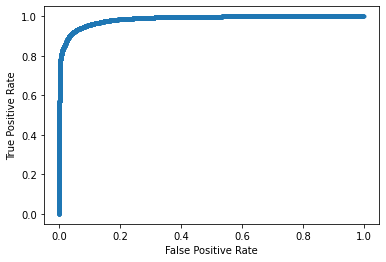

In [43]:
#'Customer Type', 'Cleanliness', 'Leg room service', 'On-board service', 'Inflight wifi service', 'Seat comfort',
#          'Type of Travel', 'Inflight entertainment', 'Class_Business', 'Online boarding', 'satisfaction'

train, test = train_test_split(df2, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']


model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('logistic', LogisticRegression(solver='liblinear'))])
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()
y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Naivni Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB

ROC Score= 0.917527618
Accuracy=  0.858676 


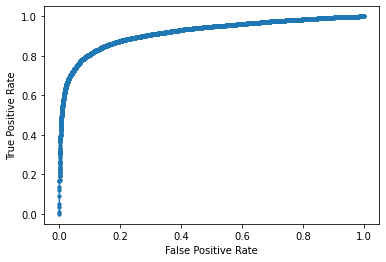

In [45]:
train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']


model = GaussianNB()
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test)
y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
plt.show()

ROC Score= 0.927343271
Accuracy=  0.870839 


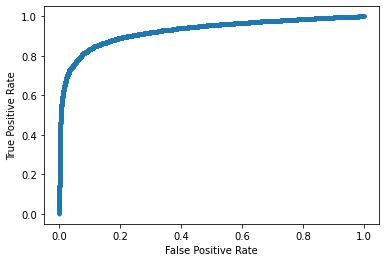

In [46]:
train, test = train_test_split(df2, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']


model = GaussianNB()
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test)
y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
plt.show()

Naivni Bayes ne daje baš najbolje rezultate.

### Random Forest

In [47]:
from sklearn import svm

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
df3 = df[['Online boarding', 'Inflight wifi service', 'Class_Business', 'Type of Travel', 'Inflight entertainment', 
         'Seat comfort', 'Flight Distance', 'Customer Type', 'Ease of Online booking', 'Leg room service', 'satisfaction']]

df3.head()

,Online boarding,Inflight wifi service,Class_Business,Type of Travel,Inflight entertainment,Seat comfort,Flight Distance,Customer Type,Ease of Online booking,Leg room service,satisfaction
0,3,3,0,0,5,5,460,0,3,3,0
1,3,3,1,1,1,1,235,1,3,5,0
2,5,2,1,1,5,5,1142,0,2,3,1
3,2,2,1,1,2,2,562,0,5,5,0
4,5,3,1,1,3,5,214,0,3,4,1


In [50]:
train, test = train_test_split(df1, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']

n_estimators = 10
max_depth = 5

values = np.array([[0,0,0]])

for n_estimators in np.arange(1,50):
    for max_depth in np.arange(1,10):
        model = Pipeline([('RF', RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth))]) 
        model.fit(X_train, y_train)
        accuracy_test = model.score(X_test,y_test)
        values = np.append(values, [[n_estimators, max_depth, accuracy_test]], 0)
        #print('n_estimators =' , n_estimators, ' max_depth =', max_depth, ' score = ', accuracy_test)

In [51]:
transp_values = values.transpose()
np.argmax(transp_values, axis=1)

array([433,   9, 441])

In [52]:
transp_values[0,225], transp_values[1,225], transp_values[2,225]

(25.0, 9.0, 0.9318480191520581)

In [53]:
train, test = train_test_split(df1, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']

n_estimators = 10
max_depth = 5

values = np.array([[0,0,0]])

for n_estimators in np.arange(30,40):
    for max_depth in np.arange(10,15):
        model = Pipeline([('RF', RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth))]) 
        model.fit(X_train, y_train)
        accuracy_test = model.score(X_test,y_test)
        values = np.append(values, [[n_estimators, max_depth, accuracy_test]], 0)
        #print('n_estimators =' , n_estimators, ' max_depth =', max_depth, ' score = ', accuracy_test)

In [54]:
transp_values = values.transpose()
np.argmax(transp_values, axis=1)

array([46,  5, 20])

In [55]:
transp_values[0,30], transp_values[1,30], transp_values[2,30]

(35.0, 14.0, 0.9410765310062553)

In [56]:
train, test = train_test_split(df1, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']

n_estimators = 10
max_depth = 5

values = np.array([[0,0,0]])

for n_estimators in np.arange(30,40):
    for max_depth in np.arange(15,20):
        model = Pipeline([('RF', RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth))]) 
        model.fit(X_train, y_train)
        accuracy_test = model.score(X_test,y_test)
        values = np.append(values, [[n_estimators, max_depth, accuracy_test]], 0)
        #print('n_estimators =' , n_estimators, ' max_depth =', max_depth, ' score = ', accuracy_test)

In [57]:
transp_values = values.transpose()
np.argmax(transp_values, axis=1)

array([46,  5, 46])

In [58]:
transp_values[0,21], transp_values[1,21], transp_values[2,21]

(34.0, 15.0, 0.9413854351687388)

In [59]:
train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']

n_estimators = 10
max_depth = 5

values = np.array([[0,0,0]])

for n_estimators in np.array([30,35,40]):
    for max_depth in np.arange(15,20):
        model = Pipeline([('RF', RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth))]) 
        model.fit(X_train, y_train)
        accuracy_test = model.score(X_test,y_test)
        values = np.append(values, [[n_estimators, max_depth, accuracy_test]], 0)
        #print('n_estimators =' , n_estimators, ' max_depth =', max_depth, ' score = ', accuracy_test)

In [60]:
transp_values = values.transpose()
np.argmax(transp_values, axis=1)

array([11,  5, 14])

In [61]:
transp_values[0,9], transp_values[1,9], transp_values[2,9]

(35.0, 18.0, 0.9608077843848946)

In [62]:
train, test = train_test_split(df3, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']

n_estimators = 10
max_depth = 5

values = np.array([[0,0,0]])

for n_estimators in np.array([30,35,40]):
    for max_depth in np.arange(15,20):
        model = Pipeline([('RF', RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth))]) 
        model.fit(X_train, y_train)
        accuracy_test = model.score(X_test,y_test)
        values = np.append(values, [[n_estimators, max_depth, accuracy_test]], 0)
        #print('n_estimators =' , n_estimators, ' max_depth =', max_depth, ' score = ', accuracy_test)

In [63]:
transp_values = values.transpose()
np.argmax(transp_values, axis=1)

array([11,  5,  2])

In [64]:
transp_values[0,2], transp_values[1,2], transp_values[2,2]

(30.0, 16.0, 0.9449378330373002)

ROC Score= 0.993391439
Accuracy=  0.960615 


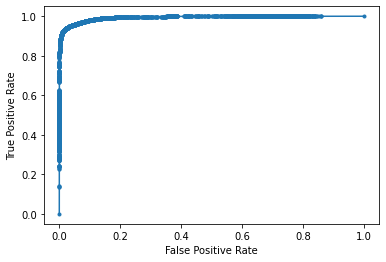

In [65]:
train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

X_test = test.drop('satisfaction',axis=1)
y_test = test['satisfaction']

model = Pipeline([('RF', RandomForestClassifier(n_estimators=35,max_depth=18))]) 
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test)

y_proba=model.predict_proba(X_test)
y_proba=y_proba[:,1]
auc=roc_auc_score(y_test, y_proba)
print('ROC Score= %.9f' % (auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba)
plt.plot(lr_fpr, lr_tpr, marker='.')
tocnost = "Accuracy= %9f " % (accuracy_test)
print(tocnost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()